<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Quantum Fourier Transform*_ 

In this tutorial, we [introduce](#introduction) the quantum fourier transform (QFT), [derive](#circuit) the circuit, QASM and QISKit code, before [implementing](#implementation) it using the simulator and five qubit device.

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

***
### Contributors
Anna Phan

## Introduction <a id='introduction'></a>

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation. 

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

## Circuit and Code <a id='circuit'></a>

We've actually already seen the quantum Fourier transform for when $N = 2$, it is the Hadamard operator ($H$):
$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$
Suppose we have the single qubit state $\alpha \vert 0 \rangle + \beta \vert 1 \rangle$, if we apply the $H$ operator to this state, we obtain the new state:
$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$
Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

So what does the quantum Fourier transform look like for larger N? Let's derive a circuit for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1...x_n \rangle$ where $x_1$ is the most significant bit.

\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle \:\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 ... y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1...y_k, y/2^n = \sum_{k=1}^n y_k/2^k \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=0}^n e^{2 \pi i x y_k/2^k } \vert y_1 ... y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} \\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} \\
& = \frac{1}{\sqrt{N}} \left(\vert0\rangle + e^{2 \pi i[0.x_n]} \vert1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2...x_{n-1}.x_n]} \vert1\rangle\right) \:\text{as}\: e^{2 \pi i x/2^k} = e^{2 \pi i[0.x_k...x_n]} 
\end{aligned}

This is a very useful form of the QFT for $N=2^n$ as only the last qubit depends on the the
values of all the other input qubits and each further bit depends less and less on the input qubits. Furthermore, note that $e^{2 \pi i.0.x_n}$ is either $+1$ or $-1$, which resembles the Hadamard transform.

For the QFT circuit, together with the Hadamard gate, we will also need the controlled phase rotation gate, as defined in [OpenQASM](https://github.com/QISKit/openqasm), to implement the dependencies between the bits:
$$CU_1(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}$$

Before we create the circuit code for general $N=2^n$, let's look at $N=8,n=3$:
$$QFT_8\vert x_1x_2x_3\rangle = \frac{1}{\sqrt{8}} \left(\vert0\rangle + e^{2 \pi i[0.x_3]} \vert1\rangle\right) \otimes \left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right) \otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2.x_3]} \vert1\rangle\right) $$

The steps to creating the circuit for $\vert y_1y_2x_3\rangle = QFT_8\vert x_1x_2x_3\rangle$ would be:
1. Apply a Hadamard to $\vert x_3 \rangle$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i.0.x_3} \vert1\rangle\right) = \frac{1}{\sqrt{2}}\left(\vert0\rangle + (-1)^{x_3} \vert1\rangle\right)$
2. Apply a Hadamard to $\vert x_2 \rangle$, then depending on $k_3$ (before the Hadamard gate) a $CU_1(\frac{\pi}{2})$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right)$
3. Apply a Hadamard to $\vert x_1 \rangle$, then $CU_1(\frac{\pi}{2})$ depending on $k_2$, and $CU_1(\frac{\pi}{4})$ depending on $k_3$.
4. Measure the bits in reverse order, that is $y_3 = x_1, y_2 = x_2, y_1 = y_3$.

In the Quantum Experience composer (if controlled phase rotation gates were available) this circuit would look like:
<img src="../images/qft3.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center">

In QASM, it is:
```
qreg q[3];
creg c[3];
h q[0];
cu1(pi/2) q[1],q[0];
h q[1];
cu1(pi/4) q[2],q[0];
cu1(pi/2) q[2],q[1];
h q[2];
```

In QISKit, it is:
```
q = QuantumRegister(3)
c = ClassicalRegister(3)

qft3 = QuantumCircuit(q, c)
qft3.h(q[0])
qft3.cu1(math.pi/2.0, q[1], q[0])
qft3.h(q[1])
qft3.cu1(math.pi/4.0, q[2], q[0])
qft3.cu1(math.pi/2.0, q[2], q[1])
qft3.h(q[2])
```

For $N=2^n$, this can be generalised, as in the `qft` function in [tools.qi](https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/tools/qi/qi.py):
```
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])
```

## Implementation <a id='implementation'></a>

In [1]:
import math

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.backends.ibmq import least_busy

# useful additional packages 
from qiskit.wrapper.jupyter import *
from qiskit.tools.visualization import plot_histogram

In [2]:
IBMQ.load_accounts()

First let's define the QFT function, as well as a function that creates a state from which a QFT will return 1:

In [3]:
def input_state(circ, q, n):
    """n-qubit input state for QFT that produces output 1."""
    for j in range(n):
        circ.h(q[j])
        circ.u1(math.pi/float(2**(j)), q[j]).inverse()

def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])

Let's now implement a QFT on a prepared three qubit input state that should return $001$:

In [4]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qft3 = QuantumCircuit(q, c)

input_state(qft3, q, 3)
qft(qft3, q, 3)
for i in range(3):
    qft3.measure(q[i], c[i])
print(qft3.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
h q0[0];
u1(-3.14159265358979) q0[0];
h q0[1];
u1(-1.57079632679490) q0[1];
h q0[2];
u1(-0.785398163397448) q0[2];
h q0[0];
cu1(1.57079632679490) q0[1],q0[0];
h q0[1];
cu1(0.785398163397448) q0[2],q0[0];
cu1(1.57079632679490) q0[2],q0[1];
h q0[2];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];



In [5]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")

simulate = execute(qft3, backend=backend, shots=1024).result()
simulate.get_counts()

{'001': 1024}

We indeed see that the outcome is always $001$ when we execute the code on the simulator.


We then see how the same circuit can be executed on real-device backends.

In [6]:
%%qiskit_job_status

# Use the IBM Quantum Experience
backend = least_busy(IBMQ.backends(simulator=False))
shots = 1024

job_exp = execute(qft3, backend=backend, shots=shots)

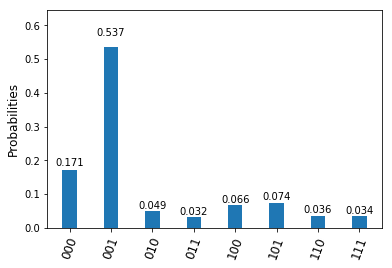

In [7]:
results = job_exp.result()
plot_histogram(results.get_counts())

We see that the highest probability outcome $001$ when we execute the code on `IBMQ device`.